
Necessary imports:


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import CSVLogger

# building model
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import models

# evaluation
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

from tensorflow.keras.preprocessing.image import ImageDataGenerator
# we use this library in order to get the classes straight from folders without having
# to manually iterate through them



# HEALTHY AND DISEASED DATASET

## Pre-processing the data

Here we will be extracting the data from the folders and making them into a datatype that keras can work with. The data will have a 80:10:10 split for training and validation.

We will first train a model without any rotation or transformations to the data and thereafter try to improve this model by applying transformations and then transfer learning.

In [1]:
# get the data
all_data_dir=r'S:\Research Project 2022\Diseased_Data_CNN'
split_data_dir=r"S:\Research Project 2022\Diseased_Data_CNN_Split"

Splitting the data into 80/10/10 train/ validation test split by splitting the original data (ONLY RUN THIS ONCE, HOWEVER SINCE THE DATA GIVEN FOR THE RESEARCH IS ALREADY SPLIT BY THIS CODE, DOES NOT NEED TO BE RUN AT ALL)

In [2]:
import splitfolders 

input_folder = all_data_dir

output_folder= split_data_dir

splitfolders.ratio(input_folder, output= output_folder, seed=1337, ratio = (0.8, 0.1, 0.1))

Copying files: 4502 files [03:32, 21.23 files/s]


In [4]:
testDir=r"S:\Research Project 2022\Diseased_Data_CNN_Split\test"
trainDir=r"S:\Research Project 2022\Diseased_Data_CNN_Split\train"
validDir=r"S:\Research Project 2022\Diseased_Data_CNN_Split\val"

In [6]:
# ensure weights are always the same
np.random.seed(47)
tf.random.set_seed(47)

The following is the baseline model that will be used for a few of the sections. Unless the model has less or more layers, this model will be used throughout.

Building the model

In [7]:
# define baseline model
def baseline_model():

    model=models.Sequential()

    model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)))
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Conv2D(64, (3,3), activation='relu', input_shape=(150,150,3)))
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Conv2D(128, (3,3), activation='relu', input_shape=(150,150,3)))
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Conv2D(128, (3,3), activation='relu', input_shape=(150,150,3)))
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Flatten())

    model.add(layers.Dense(512, activation='relu'))

    model.add(layers.Dense(22, activation='softmax'))
    model.summary()
    
    return model



The code below are reused multiple times thus are better to be contained in functions. They are mainly for plotting and data visualisation purposes.

In [129]:
def plotConfusionMatrix(labels,predictions, test_gen): 

    cm = confusion_matrix(labels, predictions)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(test_gen.class_indices.keys()))

    fig, ax = plt.subplots(figsize=(10,10))
    disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation='vertical')

    plt.show()



In [9]:
def plotGraph(history, titleName):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,2.5)
    plt.title(titleName)
    plt.show()

The code below is for testing the models. Due to constant re-use, it was made into a function.

In [11]:
def testModel(model, test_gen, filePath, titleName, totBatchNo):
    batch_num=0
    predictions = np.array([])
    labels =  np.array([])
    print('Batch=', end='')

    # ===============================================================
    # GET TEST MODEL PREDICTIONS
    # ===============================================================
    # loop through the test set
    for x, y in test_gen:
        predictions = np.concatenate([predictions, np.argmax(model.predict(x,verbose = 0), axis = -1)])
        labels = np.concatenate([labels, np.argmax(y, axis=-1)])
        batch_num+=1
        print(batch_num,end='...')

        # ensure we don't repeat the samples when checking accuracy and stop at the right batch 
        if (batch_num>totBatchNo):
            break

    # a check that the batch_num was correct
    try:
        assert len(predictions)== len(labels)
    except AssertionError as e:
        print(e)
    # =============================================================
    # GET ACCURACY PER CLASS
    # =============================================================

    # get the confusion matrix in order to calculate the accuracy per class
    tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()
    cm = confusion_matrix(labels, predictions)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm.diagonal()
    acc_each_class = cm.diagonal()

    print('\nAccuracy of each class: \n')


    # =============================================================
    # WRITE TO TEXT FILE 
    # =============================================================

    with open(filePath, 'w') as f:
        f.write(titleName+str(accuracy_score(labels, predictions))+'\n\n\nAccuracy per class:\n\n')
        for i in range(len(list(test_gen.class_indices.keys()))):
            print(list(test_gen.class_indices.keys())[i], ' : ', acc_each_class[i])
            f.write('\n'+str(list(test_gen.class_indices.keys())[i])+ ' : '+ str(acc_each_class[i]))
    print('\n')
    print('Test accuracy:',accuracy_score(labels, predictions))
    return labels, predictions

    

### 1. RGB Features

This model only contains RGB features. 

DATA
______

1. The log of train accuracy, train loss, validation accuracy, validation loss can be found in [this log file](./Health_Diseased_Results/1.%20rgb%20results/train_test_valid_HD.log) 

2. The last model can be loaded from [this model file](./Health_Diseased_Results/1.%20rgb%20results/ModelHD_RGB.h5) 

3. The test results for the last model can be found in [this text file](./Health_Diseased_Results/1.%20rgb%20results/RGB.txt) 

4. The best model can be loaded from [this model file](./Health_Diseased_Results/1.%20rgb%20results/Best_train_test_validation_HD.h5) 

5. The results for the best model can be found in [this text file](./Health_Diseased_Results/1.%20rgb%20results/RGB_best_model.txt) 


In [12]:
all_data_gen=ImageDataGenerator(rescale=1./155)

# there is a 70-30 training, validation split on the data
# this is without rotation invariance etc
# we rescale our rgb values to flot values

img_height=150
img_width= 150
batch_size=2
train_gen=all_data_gen.flow_from_directory(trainDir,target_size=(img_height, img_width), batch_size=6, class_mode='categorical')
valid_gen=all_data_gen.flow_from_directory(validDir,target_size=(img_height, img_width), batch_size=11, class_mode='categorical')
test_gen=all_data_gen.flow_from_directory(testDir,target_size=(img_height, img_width), batch_size=4, class_mode='categorical')


Found 3594 images belonging to 22 classes.
Found 440 images belonging to 22 classes.
Found 468 images belonging to 22 classes.


In [14]:
model=baseline_model()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 17, 17, 128)     

In [15]:
# save the best model only where HD= Healthy Diseased
earlyStopping=keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
checkpt=keras.callbacks.ModelCheckpoint("./Health_Diseased_Results/1. rgb results/Best_train_test_validation_HD.h5",monitor='val_loss',  save_best_only=True)
csv_logger = CSVLogger('./Health_Diseased_Results/1. rgb results/train_test_valid_HD.log', separator=',', append=True)

In [16]:
history=model.fit(train_gen, steps_per_epoch=599, epochs=20, validation_data=valid_gen, validation_steps=40, callbacks=[csv_logger,earlyStopping,checkpt])

Epoch 1/20
599/599 [==============================] - 1398s 2s/step - loss: 2.0870 - accuracy: 0.3450 - val_loss: 1.4971 - val_accuracy: 0.5364
Epoch 2/20
599/599 [==============================] - 1169s 2s/step - loss: 1.1389 - accuracy: 0.6208 - val_loss: 0.9244 - val_accuracy: 0.7295
Epoch 3/20
599/599 [==============================] - 546s 911ms/step - loss: 0.7490 - accuracy: 0.7585 - val_loss: 0.7339 - val_accuracy: 0.7818
Epoch 4/20
599/599 [==============================] - 610s 1s/step - loss: 0.5339 - accuracy: 0.8175 - val_loss: 0.6409 - val_accuracy: 0.7636
Epoch 5/20
599/599 [==============================] - 631s 1s/step - loss: 0.4050 - accuracy: 0.8642 - val_loss: 0.6786 - val_accuracy: 0.8068
Epoch 6/20
599/599 [==============================] - 613s 1s/step - loss: 0.3236 - accuracy: 0.8831 - val_loss: 0.7254 - val_accuracy: 0.8000


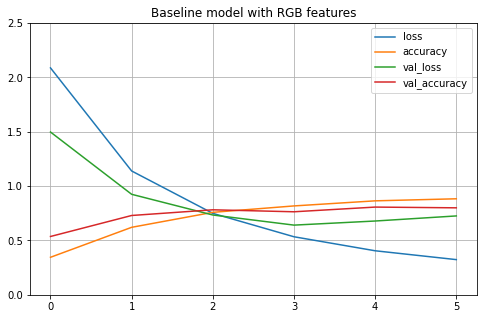

In [17]:
plotGraph(history, "Baseline model with RGB features")

In [25]:

# Testing the model
labels, predictions=testModel(model, test_gen, "./Health_Diseased_Results/1. rgb results/RGB.txt", "TEST RESULTS:\n\nRGB Test accuracy:", 117)

Batch=1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...16...17...18...19...20...21...22...23...24...25...26...27...28...29...30...31...32...33...34...35...36...37...38...39...40...41...42...43...44...45...46...47...48...49...50...51...52...53...54...55...56...57...58...59...60...61...62...63...64...65...66...67...68...69...70...71...72...73...74...75...76...77...78...79...80...81...82...83...84...85...86...87...88...89...90...91...92...93...94...95...96...97...98...99...100...101...102...103...104...105...106...107...108...109...110...111...112...113...114...115...116...117...118...
Accuracy of each class: 

Alstonia Scholaris Diseased  :  0.8461538461538461
Alstonia Scholaris Healthy  :  0.6666666666666666
Arjun Diseased  :  0.8
Arjun Healthy  :  0.7727272727272727
Bael Diseased  :  0.8461538461538461
Basil Healthy  :  0.8
Chinar Diseased  :  0.6666666666666666
Chinar Healthy  :  0.4166666666666667
Gauva Diseased  :  0.7333333333333333
Gauva Healthy  :  0.793103448275

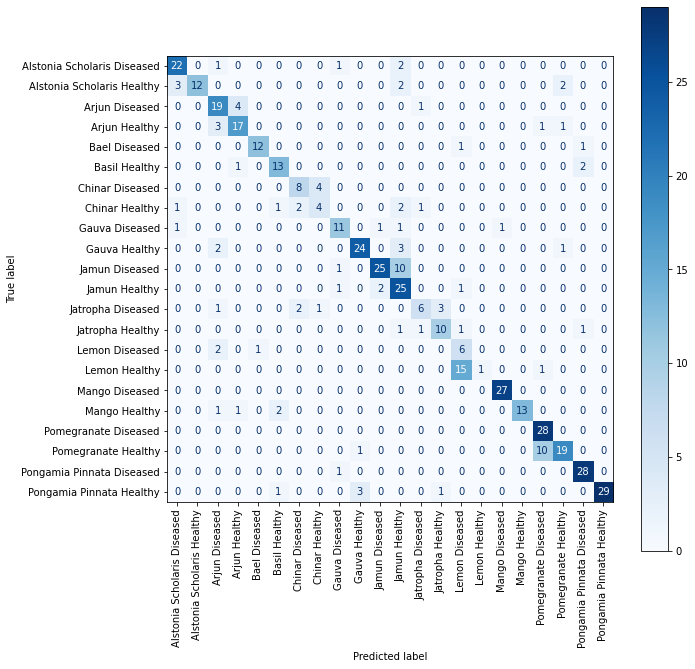

In [19]:
plotConfusionMatrix(labels,predictions,test_gen)

In [20]:
model.save("./Health_Diseased_Results/1. rgb results/ModelHD_RGB.h5")

In [21]:
K.clear_session()
del model

In [22]:
#  ================================================
#  USING THE BEST MODEL
#  ================================================

model = keras.models.load_model(r'.\Health_Diseased_Results\1. rgb results\Best_train_test_validation_HD.h5')


labels, predictions=testModel(model, test_gen, './Health_Diseased_Results/1. rgb results/RGB.txt', 'TEST RESULTS:\n\nRGB Test accuracy:', 117)


Batch=1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...16...17...18...19...20...21...22...23...24...25...26...27...28...29...30...31...32...33...34...35...36...37...38...39...40...41...42...43...44...45...46...47...48...49...50...51...52...53...54...55...56...57...58...59...60...61...62...63...64...65...66...67...68...69...70...71...72...73...74...75...76...77...78...79...80...81...82...83...84...85...86...87...88...89...90...91...92...93...94...95...96...97...98...99...100...101...102...103...104...105...106...107...108...109...110...111...112...113...114...115...116...117...118...
Accuracy of each class: 

Alstonia Scholaris Diseased  :  0.8148148148148148
Alstonia Scholaris Healthy  :  0.45
Arjun Diseased  :  0.64
Arjun Healthy  :  0.8260869565217391
Bael Diseased  :  0.9166666666666666
Basil Healthy  :  0.7058823529411765
Chinar Diseased  :  0.8333333333333334
Chinar Healthy  :  0.5454545454545454
Gauva Diseased  :  0.6666666666666666
Gauva Healthy  :  0.75
Jamun D

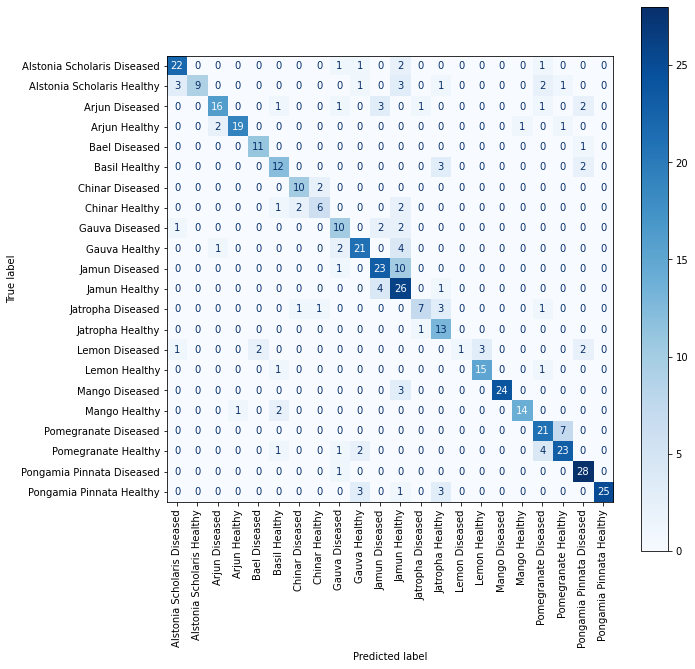

In [23]:
plotConfusionMatrix(labels,predictions,test_gen)

In [34]:
# CLEAR THE SESSION TO START A NEW ONE
K.clear_session()
del model

### 2. GRAYSCALE



This model only contains grayscale features. 

DATA
______

1. The log of train accuracy, train loss, validation accuracy, validation loss can be found in [this log file](./Health_Diseased_Results/2.%20grayscale/gray_log.log) 

2. The last model can be loaded from [this model file](./Health_Diseased_Results/2.%20grayscale/gray_model.h5) 

3. The test results for the last model can be found in [this text file](./Health_Diseased_Results/2.%20grayscale/gray_results.txt) 

4. The best model can be loaded from [this model file](./Health_Diseased_Results/2.%20grayscale/best_model_grayHD.h5) 

5. The results for the best model can be found in [this text file](./Health_Diseased_Results/2.%20grayscale/best_gray_results.txt) 


In [35]:
def to_grayscale(image):
    image = tf.image.rgb_to_grayscale(image)
    return image

In [36]:
all_data_gen=ImageDataGenerator(rescale=1./155, preprocessing_function = to_grayscale)


img_height=150
img_width= 150
batch_size=2
train_gen=all_data_gen.flow_from_directory(trainDir,target_size=(img_height, img_width), batch_size=6, class_mode='categorical')
valid_gen=all_data_gen.flow_from_directory(validDir,target_size=(img_height, img_width), batch_size=11, class_mode='categorical')
test_gen=all_data_gen.flow_from_directory(testDir,target_size=(img_height, img_width), batch_size=4, class_mode='categorical')


Found 3594 images belonging to 22 classes.
Found 440 images belonging to 22 classes.
Found 468 images belonging to 22 classes.


In [37]:
model=baseline_model()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [38]:
# save the best model only where HD= Healthy Diseased
earlyStopping=keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
checkpt=keras.callbacks.ModelCheckpoint("./Health_Diseased_Results/2. grayscale/best_model_grayHD.h5",monitor='val_loss',  save_best_only=True)
csv_logger = CSVLogger('./Health_Diseased_Results/2. grayscale/gray_log.log', separator=',', append=True)

In [39]:
history=model.fit(train_gen, steps_per_epoch=599, epochs=20, validation_data=valid_gen, validation_steps=40, callbacks=[csv_logger,earlyStopping,checkpt])

Epoch 1/20
599/599 [==============================] - 603s 1s/step - loss: 2.0778 - accuracy: 0.3536 - val_loss: 1.2717 - val_accuracy: 0.5432
Epoch 2/20
599/599 [==============================] - 637s 1s/step - loss: 1.0135 - accuracy: 0.6603 - val_loss: 1.0085 - val_accuracy: 0.6614
Epoch 3/20
599/599 [==============================] - 533s 889ms/step - loss: 0.7126 - accuracy: 0.7577 - val_loss: 0.7915 - val_accuracy: 0.7341
Epoch 4/20
599/599 [==============================] - 617s 1s/step - loss: 0.5111 - accuracy: 0.8269 - val_loss: 0.8036 - val_accuracy: 0.7295
Epoch 5/20
599/599 [==============================] - 537s 896ms/step - loss: 0.3597 - accuracy: 0.8745 - val_loss: 0.7089 - val_accuracy: 0.7591
Epoch 6/20
599/599 [==============================] - 590s 986ms/step - loss: 0.2620 - accuracy: 0.9054 - val_loss: 0.7972 - val_accuracy: 0.7591
Epoch 7/20
599/599 [==============================] - 646s 1s/step - loss: 0.2092 - accuracy: 0.9268 - val_loss: 0.8194 - val_accurac

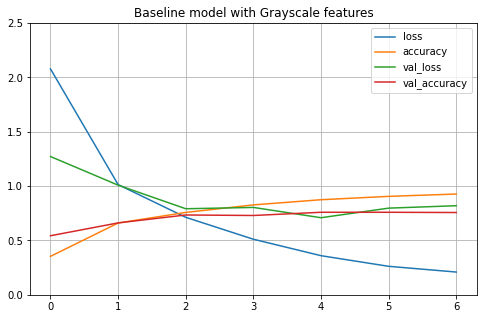

In [40]:
plotGraph(history, "Baseline model with Grayscale features")

In [41]:

# Testing the model
labels, predictions=testModel(model, test_gen, "./Health_Diseased_Results/2. grayscale/gray_results.txt", "TEST RESULTS:\n\nGrayscale Test accuracy:", 117)

Batch=1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...16...17...18...19...20...21...22...23...24...25...26...27...28...29...30...31...32...33...34...35...36...37...38...39...40...41...42...43...44...45...46...47...48...49...50...51...52...53...54...55...56...57...58...59...60...61...62...63...64...65...66...67...68...69...70...71...72...73...74...75...76...77...78...79...80...81...82...83...84...85...86...87...88...89...90...91...92...93...94...95...96...97...98...99...100...101...102...103...104...105...106...107...108...109...110...111...112...113...114...115...116...117...118...
Accuracy of each class: 

Alstonia Scholaris Diseased  :  0.8846153846153846
Alstonia Scholaris Healthy  :  0.21052631578947367
Arjun Diseased  :  0.84
Arjun Healthy  :  0.7727272727272727
Bael Diseased  :  0.9230769230769231
Basil Healthy  :  0.75
Chinar Diseased  :  0.75
Chinar Healthy  :  0.36363636363636365
Gauva Diseased  :  0.7333333333333333
Gauva Healthy  :  0.896551724137931
Jamun 

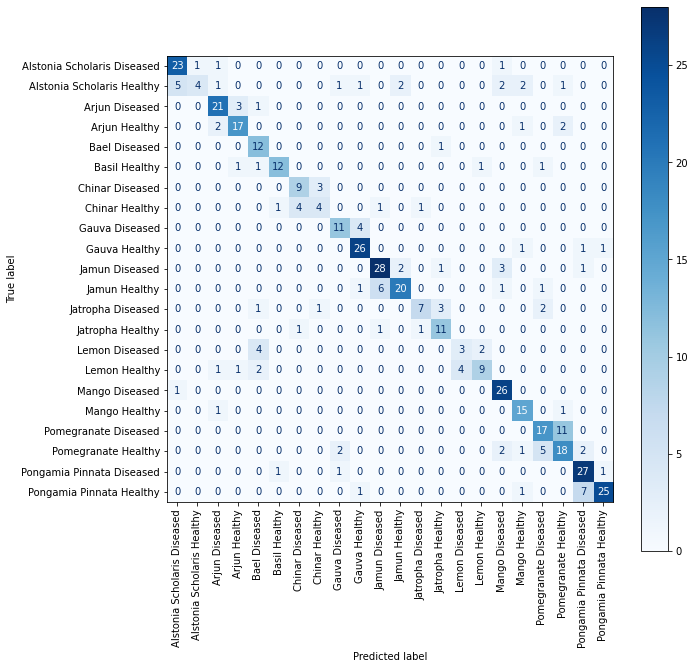

In [42]:
plotConfusionMatrix(labels,predictions,test_gen)

In [43]:
model.save("./Health_Diseased_Results/2. grayscale/gray_model.h5")

In [ ]:
# CLEAR THE SESSION TO START A NEW ONE
K.clear_session()
del model

In [127]:
#  ================================================
#  USING THE BEST MODEL
#  ================================================

model = keras.models.load_model(r'Health_Diseased_Results\2. grayscale\best_model_grayHD.h5')


labels, predictions=testModel(model, test_gen, './Health_Diseased_Results/2. grayscale/best_gray_results.txt', 'TEST RESULTS:\n\nBest Grayscale Test accuracy:', 117)


Batch=1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...16...17...18...19...20...21...22...23...24...25...26...27...28...29...30...31...32...33...34...35...36...37...38...39...40...41...42...43...44...45...46...47...48...49...50...51...52...53...54...55...56...57...58...59...60...61...62...63...64...65...66...67...68...69...70...71...72...73...74...75...76...77...78...79...80...81...82...83...84...85...86...87...88...89...90...91...92...93...94...95...96...97...98...99...100...101...102...103...104...105...106...107...108...109...110...111...112...113...114...115...116...117...118...
Accuracy of each class: 

Alstonia Scholaris Diseased  :  0.8518518518518519
Alstonia Scholaris Healthy  :  0.7647058823529411
Arjun Diseased  :  0.64
Arjun Healthy  :  0.8636363636363636
Bael Diseased  :  0.9230769230769231
Basil Healthy  :  0.6470588235294118
Chinar Diseased  :  0.9166666666666666
Chinar Healthy  :  0.45454545454545453
Gauva Diseased  :  0.7333333333333333
Gauva Healthy  

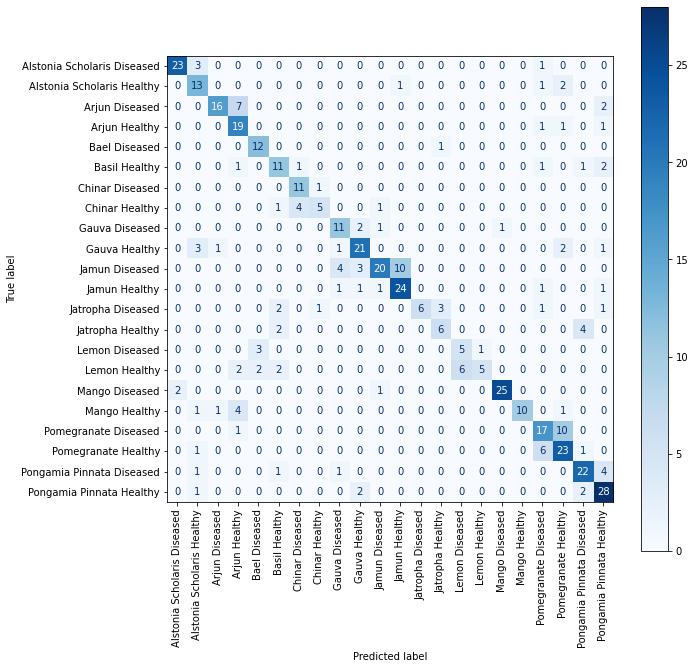

In [130]:
plotConfusionMatrix(labels,predictions,test_gen)

In [131]:
# CLEAR THE SESSION TO START A NEW ONE
K.clear_session()
del model

## 3. HSV

This model only contains HSV features. 

DATA
______

1. The log of train accuracy, train loss, validation accuracy, validation loss can be found in [this log file](./Health_Diseased_Results/3.%20hsv/hsv_results.log) 

2. The last model can be loaded from [this model file](./Health_Diseased_Results/3.%20hsv/hsv_model.h5) 

3. The test results for the last model can be found in [this text file](./Health_Diseased_Results/3.%20hsv/hsv_results.txt) 

4. The best model can be loaded from [this model file](./Health_Diseased_Results/3.%20hsv/best_hsv.h5) 

5. The results for the best model can be found in [this text file](./Health_Diseased_Results/3.%20hsv/hsv_best_results.txt) 


In [48]:

import cv2
import numpy as np
from PIL import Image

# preprocessing function for hsv colour space
def changeToHSV(image):
     # turn the image into the HSV space
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    #  convert again to uint8
    hsv[:,:,2] =  np.clip(hsv[:,:,2].astype(np.int32) , 0, 255).astype(np.uint8)
    hsv[:,:,0] =  np.clip(hsv[:,:,0].astype(np.int32) , 0, 255).astype(np.uint8)
    hsv[:,:,1] =  np.clip(hsv[:,:,1].astype(np.int32) , 0, 255).astype(np.uint8)

    return hsv

In [49]:
all_data_gen=ImageDataGenerator(rescale=1./155, preprocessing_function = changeToHSV)

# there is a 70-30 training, validation split on the data
# this is without rotation invariance etc
# we rescale our rgb values to flot values

img_height=150
img_width= 150
batch_size=2
train_gen=all_data_gen.flow_from_directory(trainDir,target_size=(img_height, img_width), batch_size=6, class_mode='categorical')
valid_gen=all_data_gen.flow_from_directory(validDir,target_size=(img_height, img_width), batch_size=11, class_mode='categorical')
test_gen=all_data_gen.flow_from_directory(testDir,target_size=(img_height, img_width), batch_size=4, class_mode='categorical')


Found 3594 images belonging to 22 classes.
Found 440 images belonging to 22 classes.
Found 468 images belonging to 22 classes.


In [50]:
model=baseline_model()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [51]:
# save the best model only where HD= Healthy Diseased
earlyStopping=keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
checkpt=keras.callbacks.ModelCheckpoint("./Health_Diseased_Results/3. hsv/best_hsv.h5",monitor='val_loss',  save_best_only=True)
csv_logger = CSVLogger('./Health_Diseased_Results/3. hsv/hsv_results.log', separator=',', append=True)

In [52]:
history=model.fit(train_gen, steps_per_epoch=599, epochs=20, validation_data=valid_gen, validation_steps=40, callbacks=[csv_logger,earlyStopping,checkpt])

Epoch 1/20
599/599 [==============================] - 514s 857ms/step - loss: 1.7682 - accuracy: 0.4441 - val_loss: 1.2276 - val_accuracy: 0.5864
Epoch 2/20
599/599 [==============================] - 549s 917ms/step - loss: 0.8626 - accuracy: 0.7268 - val_loss: 0.7971 - val_accuracy: 0.7523
Epoch 3/20
599/599 [==============================] - 589s 983ms/step - loss: 0.5304 - accuracy: 0.8183 - val_loss: 0.7321 - val_accuracy: 0.7682
Epoch 4/20
599/599 [==============================] - 608s 1s/step - loss: 0.3712 - accuracy: 0.8720 - val_loss: 0.6214 - val_accuracy: 0.8205
Epoch 5/20
599/599 [==============================] - 580s 969ms/step - loss: 0.2569 - accuracy: 0.9107 - val_loss: 0.6035 - val_accuracy: 0.8182
Epoch 6/20
599/599 [==============================] - 616s 1s/step - loss: 0.1858 - accuracy: 0.9377 - val_loss: 0.6441 - val_accuracy: 0.8136
Epoch 7/20
599/599 [==============================] - 597s 996ms/step - loss: 0.1711 - accuracy: 0.9410 - val_loss: 0.6535 - val_a

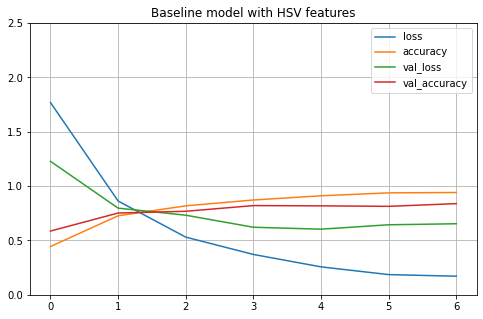

In [53]:
plotGraph(history, "Baseline model with HSV features")

In [54]:

# Testing the model
labels, predictions=testModel(model, test_gen, "./Health_Diseased_Results/3. hsv/hsv_results.txt", "TEST RESULTS:\n\nHSV Test accuracy:", 117)

Batch=1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...16...17...18...19...20...21...22...23...24...25...26...27...28...29...30...31...32...33...34...35...36...37...38...39...40...41...42...43...44...45...46...47...48...49...50...51...52...53...54...55...56...57...58...59...60...61...62...63...64...65...66...67...68...69...70...71...72...73...74...75...76...77...78...79...80...81...82...83...84...85...86...87...88...89...90...91...92...93...94...95...96...97...98...99...100...101...102...103...104...105...106...107...108...109...110...111...112...113...114...115...116...117...118...
Accuracy of each class: 

Alstonia Scholaris Diseased  :  0.9615384615384616
Alstonia Scholaris Healthy  :  0.75
Arjun Diseased  :  0.9166666666666666
Arjun Healthy  :  0.5909090909090909
Bael Diseased  :  0.8461538461538461
Basil Healthy  :  0.8235294117647058
Chinar Diseased  :  0.8333333333333334
Chinar Healthy  :  0.45454545454545453
Gauva Diseased  :  0.6666666666666666
Gauva Healthy  

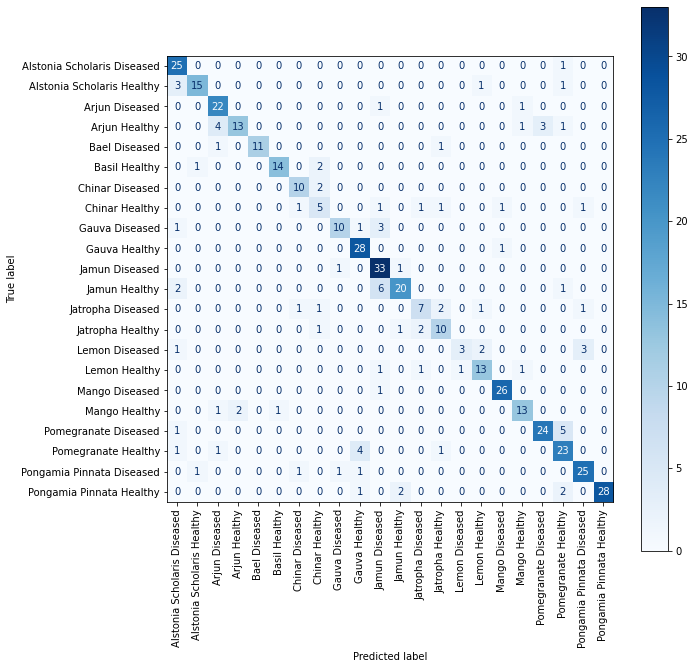

In [55]:
plotConfusionMatrix(labels,predictions,test_gen)

In [56]:
model.save("./Health_Diseased_Results/3. hsv/hsv_model.h5")

In [57]:
# CLEAR THE SESSION TO START A NEW ONE
K.clear_session()
del model

In [58]:
#  ================================================
#  USING THE BEST MODEL
#  ================================================

model = keras.models.load_model(r'.\Health_Diseased_Results\3. hsv\best_hsv.h5')


labels, predictions=testModel(model, test_gen, './Health_Diseased_Results/3. hsv/hsv_best_results.txt', 'TEST RESULTS:\n\nBest HSV Test accuracy:', 117)


Batch=1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...16...17...18...19...20...21...22...23...24...25...26...27...28...29...30...31...32...33...34...35...36...37...38...39...40...41...42...43...44...45...46...47...48...49...50...51...52...53...54...55...56...57...58...59...60...61...62...63...64...65...66...67...68...69...70...71...72...73...74...75...76...77...78...79...80...81...82...83...84...85...86...87...88...89...90...91...92...93...94...95...96...97...98...99...100...101...102...103...104...105...106...107...108...109...110...111...112...113...114...115...116...117...118...
Accuracy of each class: 

Alstonia Scholaris Diseased  :  0.9230769230769231
Alstonia Scholaris Healthy  :  0.8888888888888888
Arjun Diseased  :  0.76
Arjun Healthy  :  0.9545454545454546
Bael Diseased  :  0.8461538461538461
Basil Healthy  :  0.8
Chinar Diseased  :  0.8333333333333334
Chinar Healthy  :  0.4166666666666667
Gauva Diseased  :  0.5333333333333333
Gauva Healthy  :  0.82758620689

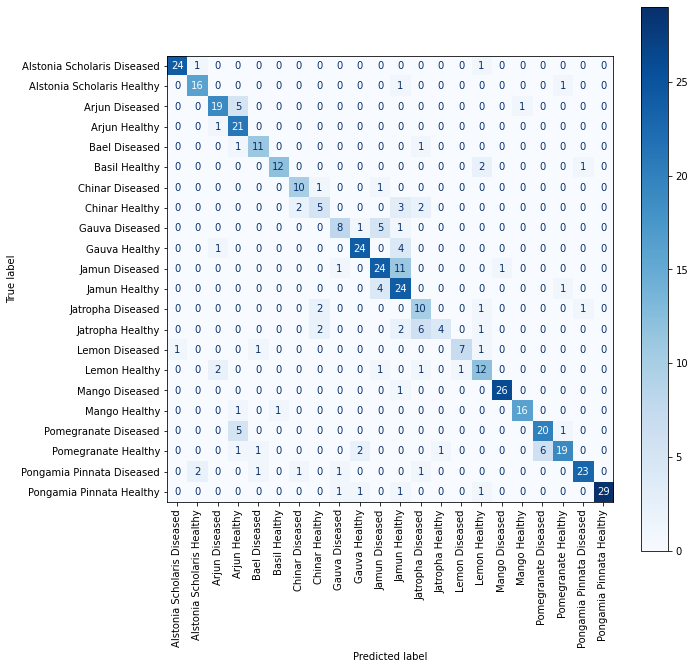

In [59]:
plotConfusionMatrix(labels,predictions,test_gen)

In [60]:
# CLEAR THE SESSION TO START A NEW ONE
K.clear_session()
del model

## 4. ROTATIONAL INVARIANCE AND HORIZONTAL+ VERTICAL FLIPPING

Since RGB performed the best, the rest of the model modifications will be done on RGB features.

DATA
______

1. The log of train accuracy, train loss, validation accuracy, validation loss can be found in [this log file](./Health_Diseased_Results/4.%20rgb%20rot%20invariant/rgb_rot.log) 

2. The last model can be loaded from [this model file](./Health_Diseased_Results/4.%20rgb%20rot%20invariant/model_all_inv.h5) 

3. The test results for the last model can be found in [this text file](./Health_Diseased_Results/4.%20rgb%20rot%20invariant/all_inv_results.txt) 

4. The best model can be loaded from [this model file](./Health_Diseased_Results/4.%20rgb%20rot%20invariant/rgb_rot_best.h5) 

5. The results for the best model can be found in [this text file](./Health_Diseased_Results/4.%20rgb%20rot%20invariant/rot_inv_best_results.txt) 


In [101]:
rot_data_gen=ImageDataGenerator(rescale=1./155, rotation_range=45, fill_mode='nearest', horizontal_flip=True, vertical_flip=True)
# keep test and validation normal
all_data_gen=ImageDataGenerator(rescale=1./155)

# there is a 70-30 training, validation split on the data
# this is without rotation invariance etc
# we rescale our rgb values to flot values

img_height=150
img_width= 150
batch_size=2
train_gen=rot_data_gen.flow_from_directory(trainDir,target_size=(img_height, img_width), batch_size=6, class_mode='categorical')
valid_gen=all_data_gen.flow_from_directory(validDir,target_size=(img_height, img_width), batch_size=11, class_mode='categorical')
test_gen=all_data_gen.flow_from_directory(testDir,target_size=(img_height, img_width), batch_size=4, class_mode='categorical')

Found 3594 images belonging to 22 classes.
Found 440 images belonging to 22 classes.
Found 468 images belonging to 22 classes.


In [102]:
model=baseline_model()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [103]:
# save the best model only
earlyStopping=keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
checkpt=keras.callbacks.ModelCheckpoint("./Health_Diseased_Results/4. rgb rot invariant/rgb_rot_best.h5", monitor='val_loss', save_best_only=True)
csv_logger = CSVLogger('./Health_Diseased_Results/4. rgb rot invariant/rgb_rot.log', separator=',', append=True)

In [104]:
history=model.fit(train_gen, steps_per_epoch=599, epochs=20, validation_data=valid_gen, validation_steps=40, callbacks=[csv_logger,earlyStopping,checkpt])

Epoch 1/20
599/599 [==============================] - 606s 1s/step - loss: 2.4785 - accuracy: 0.2176 - val_loss: 1.8188 - val_accuracy: 0.4205
Epoch 2/20
599/599 [==============================] - 1321s 2s/step - loss: 1.6792 - accuracy: 0.4524 - val_loss: 1.3718 - val_accuracy: 0.5386
Epoch 3/20
599/599 [==============================] - 1454s 2s/step - loss: 1.3195 - accuracy: 0.5735 - val_loss: 1.0069 - val_accuracy: 0.6886
Epoch 4/20
599/599 [==============================] - 559s 934ms/step - loss: 1.0571 - accuracy: 0.6494 - val_loss: 0.8774 - val_accuracy: 0.6977
Epoch 5/20
599/599 [==============================] - 623s 1s/step - loss: 0.8639 - accuracy: 0.7240 - val_loss: 0.9581 - val_accuracy: 0.6705
Epoch 6/20
599/599 [==============================] - 621s 1s/step - loss: 0.7331 - accuracy: 0.7524 - val_loss: 0.7574 - val_accuracy: 0.7364
Epoch 7/20
599/599 [==============================] - 610s 1s/step - loss: 0.6598 - accuracy: 0.7816 - val_loss: 0.6361 - val_accuracy: 0

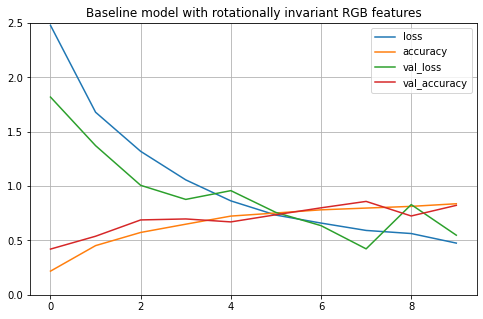

In [105]:
plotGraph(history, 'Baseline model with rotationally invariant RGB features')

In [106]:
# Testing the model
labels, predictions=testModel(model, test_gen, "./Health_Diseased_Results/4. rgb rot invariant/all_inv_results.txt", "TEST RESULTS:\n\ROTATIONAL INVARIANCE Test accuracy:", 117)

Batch=1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...16...17...18...19...20...21...22...23...24...25...26...27...28...29...30...31...32...33...34...35...36...37...38...39...40...41...42...43...44...45...46...47...48...49...50...51...52...53...54...55...56...57...58...59...60...61...62...63...64...65...66...67...68...69...70...71...72...73...74...75...76...77...78...79...80...81...82...83...84...85...86...87...88...89...90...91...92...93...94...95...96...97...98...99...100...101...102...103...104...105...106...107...108...109...110...111...112...113...114...115...116...117...118...
Accuracy of each class: 

Alstonia Scholaris Diseased  :  0.9230769230769231
Alstonia Scholaris Healthy  :  0.8
Arjun Diseased  :  0.92
Arjun Healthy  :  0.8636363636363636
Bael Diseased  :  0.8461538461538461
Basil Healthy  :  0.9375
Chinar Diseased  :  0.6153846153846154
Chinar Healthy  :  1.0
Gauva Diseased  :  0.8
Gauva Healthy  :  0.9310344827586207
Jamun Diseased  :  0.8
Jamun Healthy

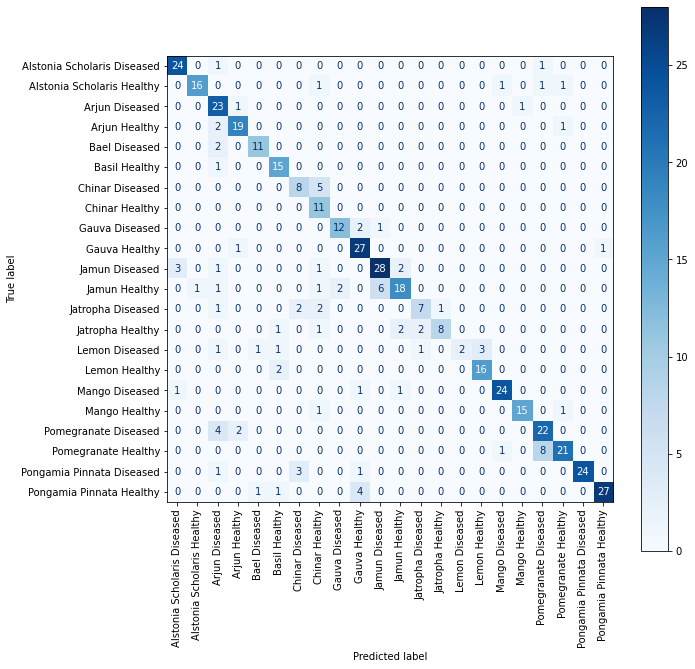

In [109]:
plotConfusionMatrix(labels,predictions,test_gen)

In [110]:
model.save("./Health_Diseased_Results/4. rgb rot invariant/model_all_inv.h5")

In [111]:
# CLEAR THE SESSION TO START A NEW ONE
K.clear_session()
del model

In [112]:
#  ================================================
#  USING THE BEST MODEL
#  ================================================

model = keras.models.load_model(r'.\Health_Diseased_Results\4. rgb rot invariant\rgb_rot_best.h5')


labels, predictions=testModel(model, test_gen, './Health_Diseased_Results/4. rgb rot invariant/rot_inv_best_results.txt', 'TEST RESULTS:\n\nBest Rotationally Invariant Features Test accuracy:', 117)


Batch=1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...16...17...18...19...20...21...22...23...24...25...26...27...28...29...30...31...32...33...34...35...36...37...38...39...40...41...42...43...44...45...46...47...48...49...50...51...52...53...54...55...56...57...58...59...60...61...62...63...64...65...66...67...68...69...70...71...72...73...74...75...76...77...78...79...80...81...82...83...84...85...86...87...88...89...90...91...92...93...94...95...96...97...98...99...100...101...102...103...104...105...106...107...108...109...110...111...112...113...114...115...116...117...118...
Accuracy of each class: 

Alstonia Scholaris Diseased  :  0.9259259259259259
Alstonia Scholaris Healthy  :  0.8333333333333334
Arjun Diseased  :  1.0
Arjun Healthy  :  0.8181818181818182
Bael Diseased  :  0.7857142857142857
Basil Healthy  :  0.9375
Chinar Diseased  :  0.8181818181818182
Chinar Healthy  :  0.6363636363636364
Gauva Diseased  :  0.9333333333333333
Gauva Healthy  :  0.966666666

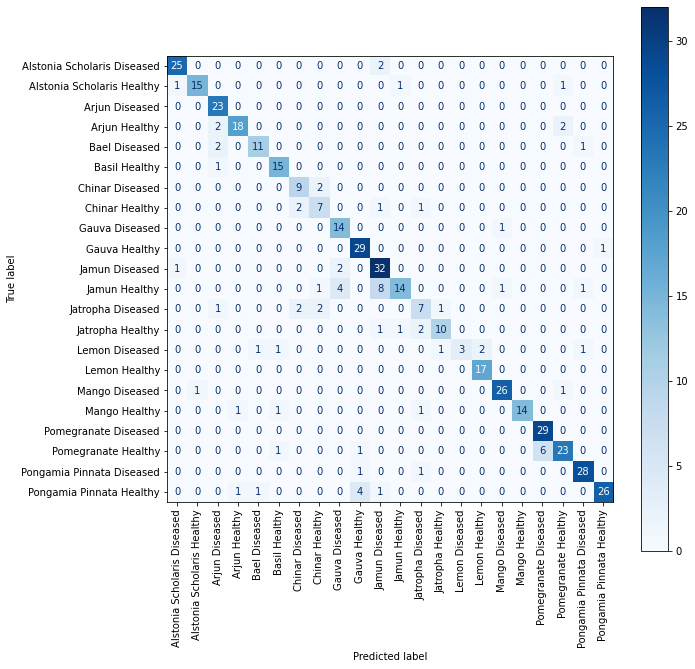

In [113]:
plotConfusionMatrix(labels,predictions,test_gen)

In [100]:
# CLEAR THE SESSION TO START A NEW ONE
K.clear_session()
del model

## 5. Translation + rotation invariant

Translation has now been added to the model in Section 4.

DATA
______

1. The log of train accuracy, train loss, validation accuracy, validation loss can be found in [this log file](./Health_Diseased_Results/5.%20transrot%20invariance/transrot_results.log) 

2. The last model can be loaded from [this model file](./Health_Diseased_Results/5.%20transrot%20invariance/transrot_model.h5) 

3. The test results for the last model can be found in [this text file](./Health_Diseased_Results/5.%20transrot%20invariance/trans_rot_results.txt) 

4. The best model can be loaded from [this model file](./Health_Diseased_Results/5.%20transrot%20invariance/transrot_best_model.h5) 

5. The results for the best model can be found in [this text file](./Health_Diseased_Results/5.%20transrot%20invariance/best_transrot_results.txt) 


In [114]:
# ImageDataGenerator translation
trans_data_gen=ImageDataGenerator(rescale=1./155,rotation_range=45, fill_mode='nearest', horizontal_flip=True, vertical_flip=True, width_shift_range=0.05, height_shift_range=0.05)

# keep test and validation normal
all_data_gen=ImageDataGenerator(rescale=1./155)


img_height=150
img_width= 150
batch_size=2
train_gen=trans_data_gen.flow_from_directory(trainDir,target_size=(img_height, img_width), batch_size=6, class_mode='categorical')
valid_gen=all_data_gen.flow_from_directory(validDir,target_size=(img_height, img_width), batch_size=11, class_mode='categorical')
test_gen=all_data_gen.flow_from_directory(testDir,target_size=(img_height, img_width), batch_size=4, class_mode='categorical')

Found 3594 images belonging to 22 classes.
Found 440 images belonging to 22 classes.
Found 468 images belonging to 22 classes.


In [115]:
model=baseline_model()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [116]:
# save the best model only where HD= Healthy Diseased
earlyStopping=keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
checkpt=keras.callbacks.ModelCheckpoint("./Health_Diseased_Results/5. transrot invariance/transrot_best_model.h5",monitor='val_loss',  save_best_only=True)
csv_logger = CSVLogger('./Health_Diseased_Results/5. transrot invariance/transrot_results.log', separator=',', append=True)

In [117]:
history=model.fit(train_gen, steps_per_epoch=599, epochs=20, validation_data=valid_gen, validation_steps=40, callbacks=[csv_logger,earlyStopping,checkpt])

Epoch 1/20
599/599 [==============================] - 548s 913ms/step - loss: 2.4738 - accuracy: 0.2012 - val_loss: 1.8920 - val_accuracy: 0.3841
Epoch 2/20
599/599 [==============================] - 609s 1s/step - loss: 1.8400 - accuracy: 0.3979 - val_loss: 1.7102 - val_accuracy: 0.4295
Epoch 3/20
599/599 [==============================] - 629s 1s/step - loss: 1.4880 - accuracy: 0.5200 - val_loss: 1.1878 - val_accuracy: 0.6000
Epoch 4/20
599/599 [==============================] - 624s 1s/step - loss: 1.2262 - accuracy: 0.5968 - val_loss: 0.9945 - val_accuracy: 0.6455
Epoch 5/20
599/599 [==============================] - 636s 1s/step - loss: 1.0950 - accuracy: 0.6402 - val_loss: 0.9146 - val_accuracy: 0.6727
Epoch 6/20
599/599 [==============================] - 701s 1s/step - loss: 0.9781 - accuracy: 0.6756 - val_loss: 0.8433 - val_accuracy: 0.7227
Epoch 7/20
599/599 [==============================] - 752s 1s/step - loss: 0.8725 - accuracy: 0.6998 - val_loss: 0.7225 - val_accuracy: 0.7

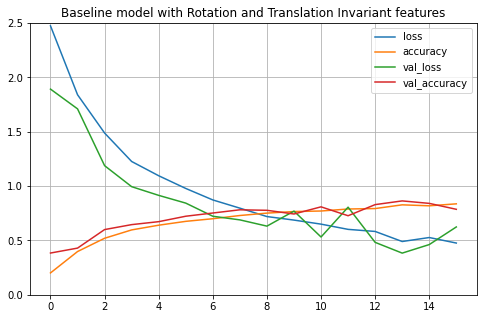

In [123]:
plotGraph(history, "Baseline model with Rotation and Translation Invariant features")

In [119]:

# Testing the model
labels, predictions=testModel(model, test_gen, "./Health_Diseased_Results/5. transrot invariance/trans_rot_results.txt", "TEST RESULTS:\n\nTranslation and Rotation Invariant Features Test accuracy:", 117)

Batch=1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...16...17...18...19...20...21...22...23...24...25...26...27...28...29...30...31...32...33...34...35...36...37...38...39...40...41...42...43...44...45...46...47...48...49...50...51...52...53...54...55...56...57...58...59...60...61...62...63...64...65...66...67...68...69...70...71...72...73...74...75...76...77...78...79...80...81...82...83...84...85...86...87...88...89...90...91...92...93...94...95...96...97...98...99...100...101...102...103...104...105...106...107...108...109...110...111...112...113...114...115...116...117...118...
Accuracy of each class: 

Alstonia Scholaris Diseased  :  0.8888888888888888
Alstonia Scholaris Healthy  :  0.631578947368421
Arjun Diseased  :  0.75
Arjun Healthy  :  0.8636363636363636
Bael Diseased  :  1.0
Basil Healthy  :  0.5
Chinar Diseased  :  1.0
Chinar Healthy  :  0.45454545454545453
Gauva Diseased  :  0.9375
Gauva Healthy  :  0.6551724137931034
Jamun Diseased  :  0.857142857142857

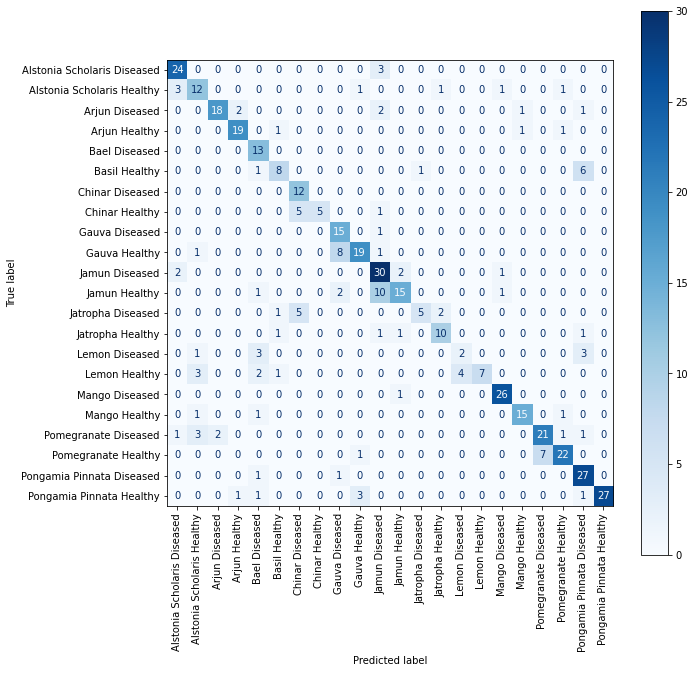

In [120]:
plotConfusionMatrix(labels,predictions,test_gen)

In [121]:
model.save("./Health_Diseased_Results/5. transrot invariance/transrot_model.h5")

In [122]:
# CLEAR THE SESSION TO START A NEW ONE
K.clear_session()
del model

In [124]:
#  ================================================
#  USING THE BEST MODEL
#  ================================================

model = keras.models.load_model(r'.\Health_Diseased_Results\5. transrot invariance\transrot_best_model.h5')


labels, predictions=testModel(model, test_gen, './Health_Diseased_Results/5. transrot invariance/best_transrot_results.txt', 'TEST RESULTS:\n\nBest Translation and Rotation Invariant Features Test accuracy:', 117)


Batch=1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...16...17...18...19...20...21...22...23...24...25...26...27...28...29...30...31...32...33...34...35...36...37...38...39...40...41...42...43...44...45...46...47...48...49...50...51...52...53...54...55...56...57...58...59...60...61...62...63...64...65...66...67...68...69...70...71...72...73...74...75...76...77...78...79...80...81...82...83...84...85...86...87...88...89...90...91...92...93...94...95...96...97...98...99...100...101...102...103...104...105...106...107...108...109...110...111...112...113...114...115...116...117...118...
Accuracy of each class: 

Alstonia Scholaris Diseased  :  1.0
Alstonia Scholaris Healthy  :  0.6666666666666666
Arjun Diseased  :  0.7916666666666666
Arjun Healthy  :  0.9090909090909091
Bael Diseased  :  0.8461538461538461
Basil Healthy  :  0.875
Chinar Diseased  :  0.75
Chinar Healthy  :  0.6363636363636364
Gauva Diseased  :  0.7857142857142857
Gauva Healthy  :  0.9
Jamun Diseased  :  0.8

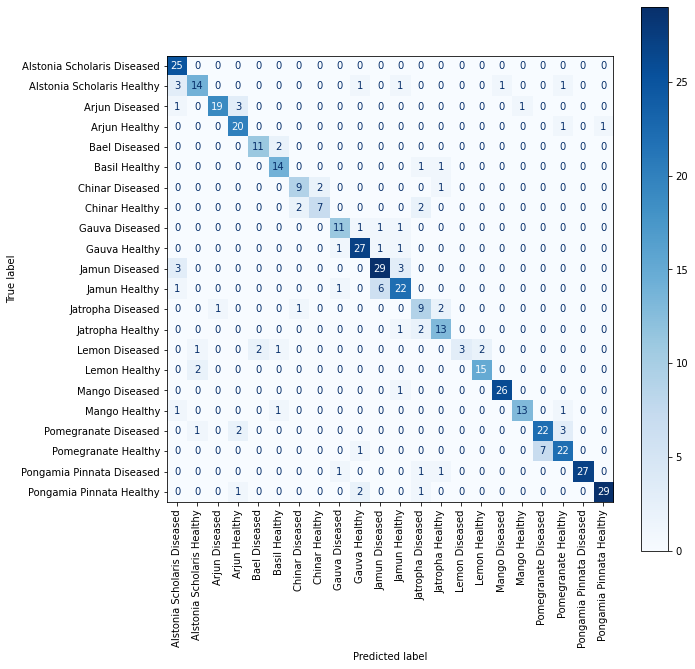

In [125]:
plotConfusionMatrix(labels,predictions,test_gen)

In [126]:
# CLEAR THE SESSION TO START A NEW ONE
K.clear_session()
del model